In [32]:
import stim, pymatching as pm, numpy as np
from IPython.display import SVG

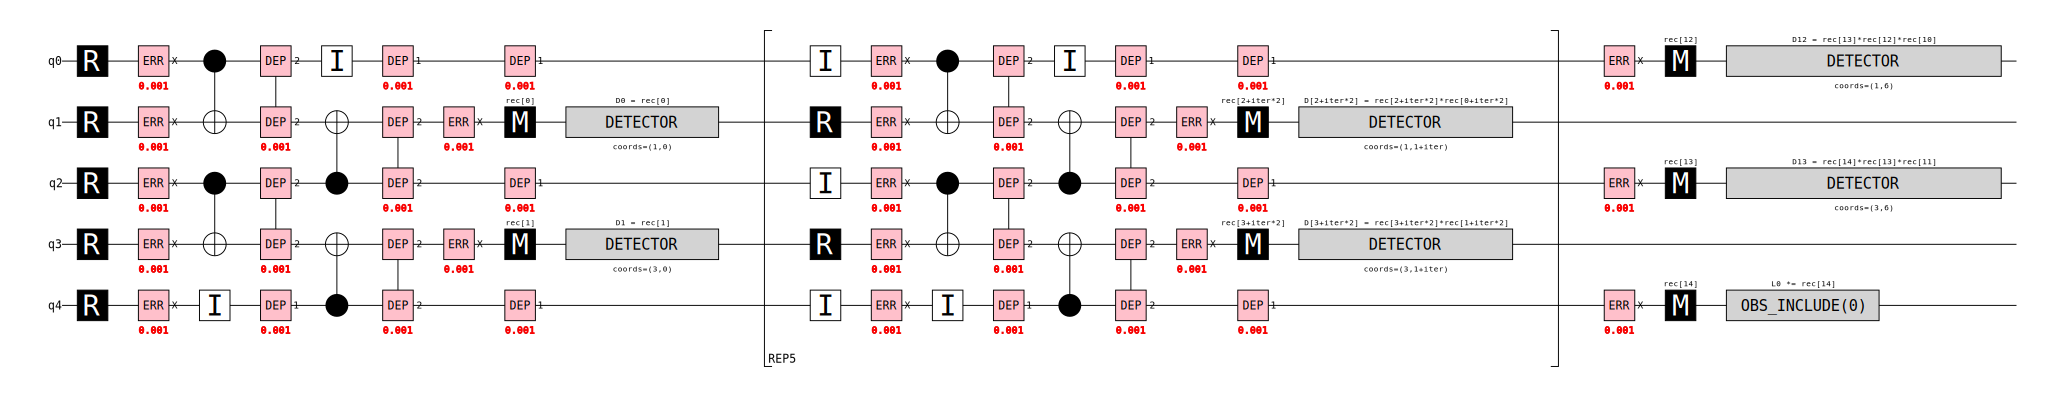

In [4]:

circ_str = """
    R 0 1 2 3 4
    X_ERROR(0.001) 0 1 2 3 4
    CX 0 1 2 3
    I 4
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    CX 2 1 4 3
    I 0
    DEPOLARIZE1(0.001) 0
    DEPOLARIZE2(0.001) 2 1 4 3
    X_ERROR(0.001) 1 3
    M 1 3
    DEPOLARIZE1(0.001) 0 2 4
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    REPEAT 5 {
        R 1 3
        I 0 2 4
        X_ERROR(0.001) 0 1 2 3 4
        CX 0 1 2 3
        I 4
        DEPOLARIZE2(0.001) 0 1 2 3
        DEPOLARIZE1(0.001) 4
        CX 2 1 4 3
        I 0
        DEPOLARIZE1(0.001) 0
        DEPOLARIZE2(0.001) 2 1 4 3
        X_ERROR(0.001) 1 3
        M 1 3
        DEPOLARIZE1(0.001) 0 2 4
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-2] rec[-4]
        DETECTOR(3, 0) rec[-1] rec[-3]
    }
    X_ERROR(0.001) 0 2 4
    M 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 0) rec[-1] rec[-2] rec[-4]

    OBSERVABLE_INCLUDE(0) rec[-1]
"""
c = stim.Circuit(circ_str)
display(SVG(str(c.diagram("timeline"))))


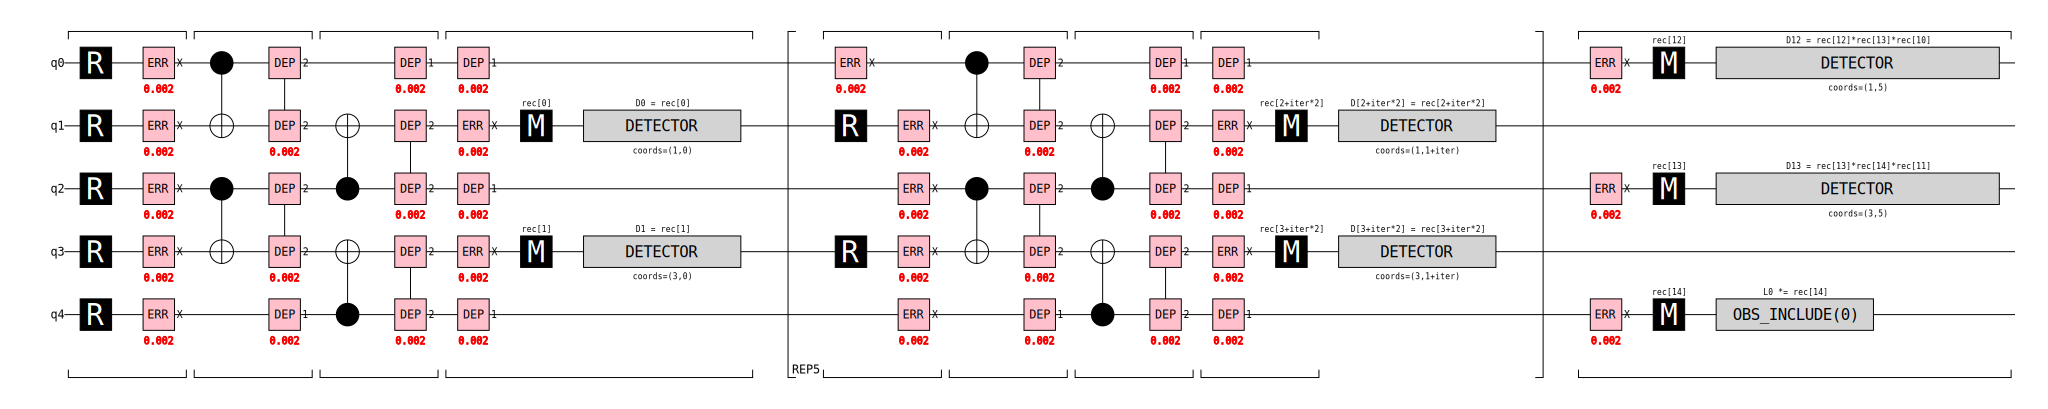

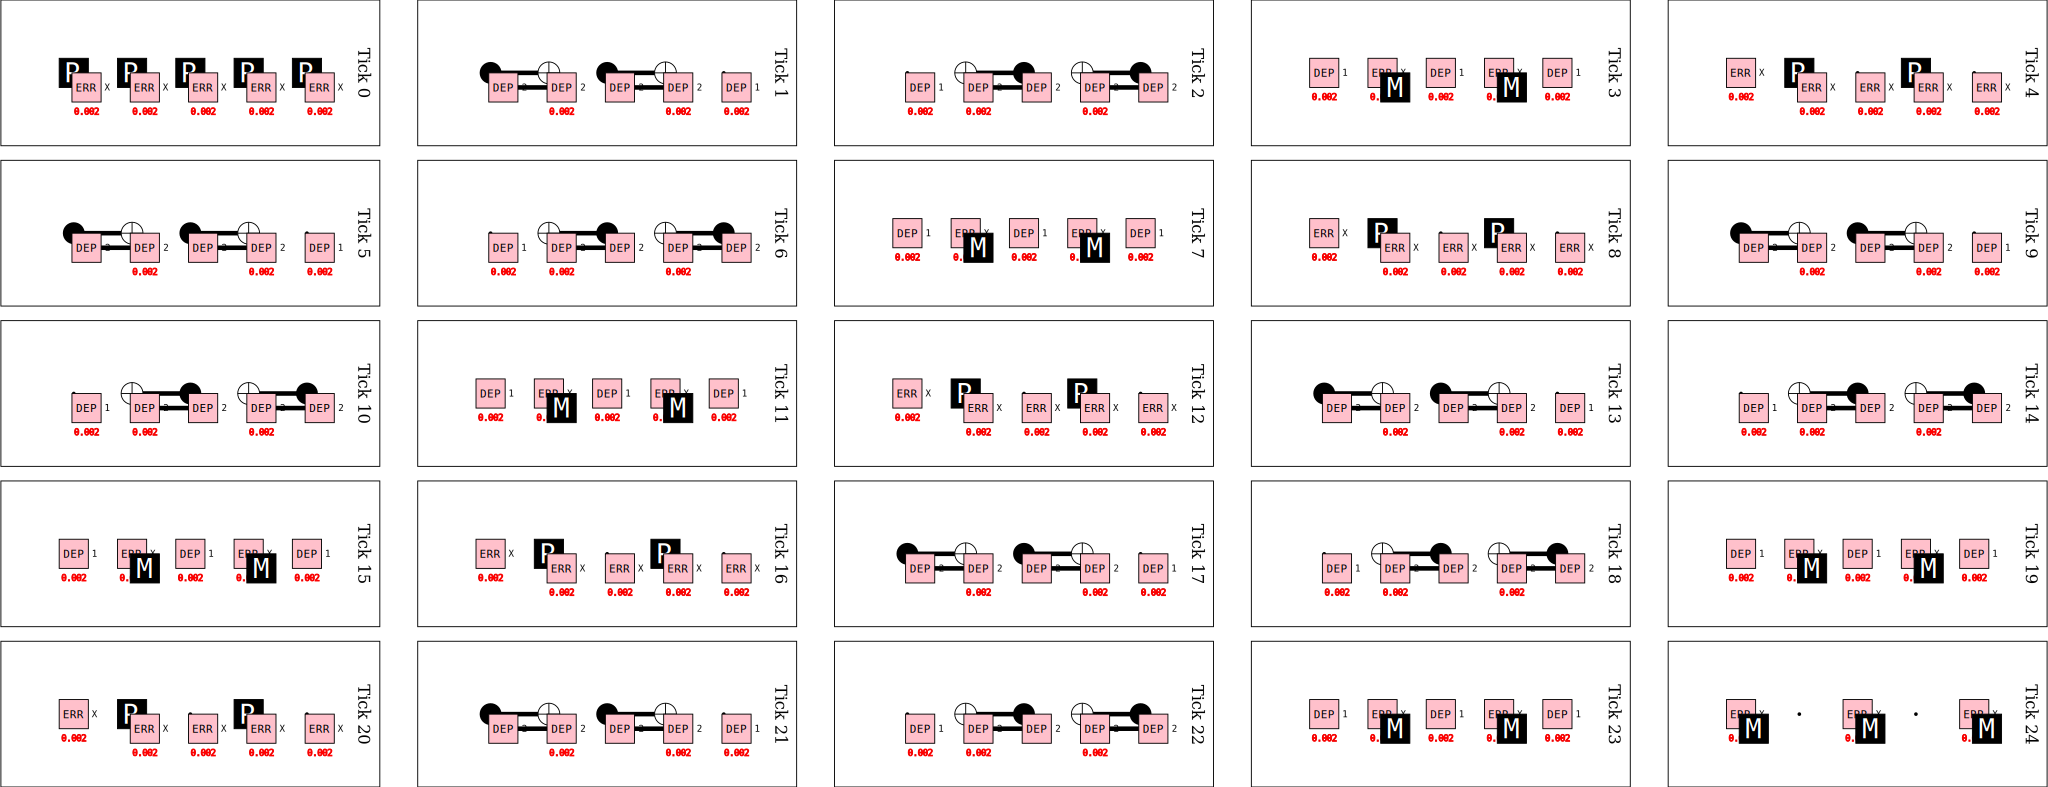

In [56]:
def repeating_part(d: int, p: float, n: int, qubits, q_dat, q_meas) -> stim.Circuit:
    c = stim.Circuit()
    c.append("R", q_meas)
    for i in qubits:
        c.append("X_ERROR", [i], p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i-1, i])
    for i in q_meas:
        c.append("DEPOLARIZE2", [i-1, i], p)
    c.append("DEPOLARIZE1", [n-1], p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i+1, i])
    for i in q_meas:
        c.append("DEPOLARIZE2", [i+1, i], p)
    c.append("DEPOLARIZE1", 0, p)
    c.append("TICK")
    for i in q_meas:
        c.append("X_ERROR", [i], p)
    for i in q_dat:
        c.append("DEPOLARIZE1", [i], p)
    for i in q_meas:
        c.append("M", [i])
    c.append("TICK")
    c.append("SHIFT_COORDS", [], [0, 1])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(-len(q_meas) + int((i-1)/2))], [i,0])

    return c

def repetition_circuit_realistic_noise(d: int, p: float, rounds: int) -> stim.Circuit:
    n = d * 2 - 1
    c = stim.Circuit()
    qubits = range(n)
    q_dat = qubits[::2]
    q_meas = qubits[1::2]
    c.append("R", range(n))
    c.append("X_ERROR", range(n), p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i-1, i])
    for i in q_meas:
        c.append("DEPOLARIZE2", [i-1, i], p)
    c.append("DEPOLARIZE1", [n-1], p)
    c.append("TICK")
    for i in q_meas:
        c.append("CNOT", [i+1, i])
    for i in q_meas:
        c.append("DEPOLARIZE2", [i+1, i], p)
    c.append("DEPOLARIZE1", 0, p)
    c.append("TICK")
    for i in q_meas:
        c.append("X_ERROR", [i], p)
    for i in q_dat:
        c.append("DEPOLARIZE1", [i], p)
    for i in q_meas:
        c.append("M", [i])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(-len(q_meas) + int((i-1)/2))], [i,0])
    c.append("TICK")
    c += rounds*repeating_part(d, p, n, qubits, q_dat, q_meas)
    
    for i in q_dat:
        c.append("X_ERROR", [i], p)
    for i in q_dat:
        c.append("M", [i])
    for i in q_meas:
        c.append("DETECTOR", [stim.target_rec(- d + int(i/2)), stim.target_rec(- d + int(i/2) + 1), stim.target_rec(- d + int(i/2) - d + 1)], [i,0])
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], 0)
    return c

d = 3

p = 0.002
rounds = 5
c = repetition_circuit_realistic_noise(d, p, rounds)

display(SVG(str(c.diagram("timeline"))))
display(SVG(str(c.diagram("timeslice-svg"))))

In [28]:
dem = c.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.00505015) D0
    error(0.00253148) D0 D1 D2 D3 D4 D5 D6 D7 D8 D9 D10 D11
    error(0.00106667) D0 D2 D3 D4 D5 D6 D7 D8 D9 D10 D11
    error(0.00253148) D0 D2 D4 D6 D8 D10
    error(0.00505015) D1
    error(0.00385807) D1 D3 D5 D7 D9 D11 L0
    error(0.00505015) D2
    error(0.00438757) D2 D3 D4 D5 D6 D7 D8 D9 D10 D11
    error(0.00106667) D2 D4 D5 D6 D7 D8 D9 D10 D11
    error(0.0057092) D2 D4 D6 D8 D10
    error(0.00505015) D3
    error(0.0057092) D3 D5 D7 D9 D11 L0
    error(0.00505015) D4
    error(0.00438757) D4 D5 D6 D7 D8 D9 D10 D11
    error(0.00106667) D4 D6 D7 D8 D9 D10 D11
    error(0.0057092) D4 D6 D8 D10
    error(0.00505015) D5
    error(0.0057092) D5 D7 D9 D11 L0
    error(0.00505015) D6
    error(0.00438757) D6 D7 D8 D9 D10 D11
    error(0.00106667) D6 D8 D9 D10 D11
    error(0.0057092) D6 D8 D10
    error(0.00505015) D7
    error(0.0057092) D7 D9 D11 L0
    error(0.00505015) D8
    error(0.00438757) D8 D9 D10 D11
    error(0.00570

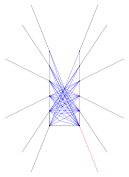

In [29]:
dem.diagram("matchgraph-svg")

In [33]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pm.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [57]:
d = 9
p = 0.002
rounds = 5
circuit = repetition_circuit_realistic_noise(d, p, rounds)
num_shots = 1_000_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 17 wrong predictions (logical errors) out of 1000000 shots
